# Performance Analysis with Alphalens

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice

In [12]:
DATA_STORE = Path('..', 'data', 'assets.h5')

## Alphalens Analysis

### Get trade prices

In [53]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices')
              .loc[idx['2006':'2017', tickers], 'adj_open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [54]:
trade_prices = get_trade_prices(tickers)

In [55]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Columns: 500 entries, A to ZION
dtypes: float64(500)
memory usage: 11.5 MB


### Load factors

In [50]:
factors = (pd.concat([pd.read_hdf('data.h5', 'factors/common'),
                      pd.read_hdf('data.h5', 'factors/formulaic')
                      .rename(columns=lambda x: f'alpha_{int(x):03}')],
                     axis=1)
           .dropna(axis=1, thresh=100000)
           .sort_index())

In [51]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, (A, 2007-01-04 00:00:00) to (ZION, 2016-12-29 00:00:00)
Columns: 135 entries, sector to alpha_101
dtypes: float64(124), int64(11)
memory usage: 1.3+ GB


In [52]:
tickers = factors.index.get_level_values('ticker').unique()

In [71]:
alpha = 'alpha_054'

In [72]:
factor = (factors[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

In [74]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 0.5% entries from factor data: 0.0% in forward returns computation and 0.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1249360 entries, (2007-01-04 00:00:00+00:00, A) to (2016-12-29 00:00:00+00:00, ZION)
Data columns (total 5 columns):
1D                 1249360 non-null float64
5D                 1249360 non-null float64
10D                1249360 non-null float64
factor             1249360 non-null float64
factor_quantile    1249360 non-null float64
dtypes: float64(5)
memory usage: 52.4+ MB


### Compute Metrics

In [98]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [100]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D
Mean Period Wise Spread (bps),1.616562,1.239560,0.685174
Ann. alpha,-0.017286,0.011855,0.012242
beta,0.056012,0.053415,0.044731


### Plot spread and cumulative returns

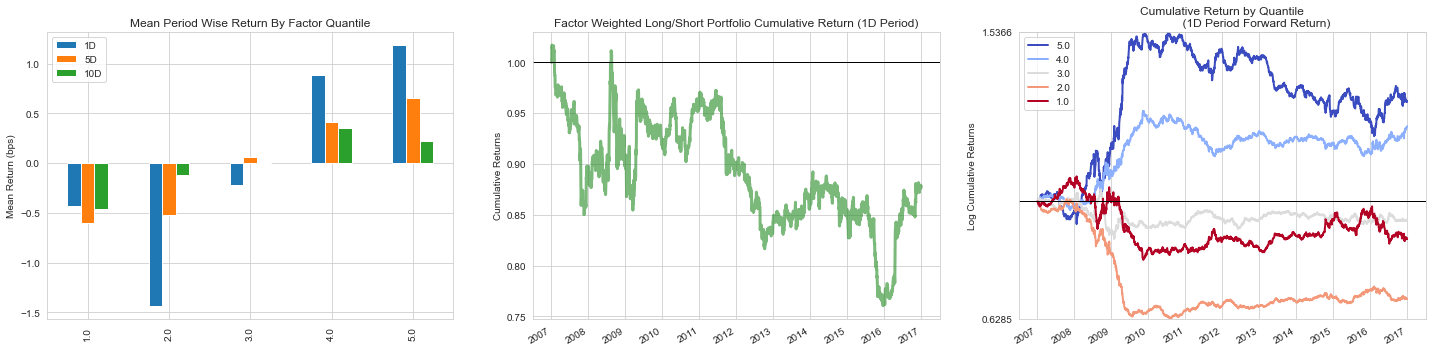

In [95]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

mean_quant_ret, std_quantile = mean_return_by_quantile(factor_data,
                                                       by_group=False,
                                                       demeaned=True)

mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])


factor_returns = perf.factor_returns(factor_data)

title = "Factor Weighted Long/Short Portfolio Cumulative Return (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[1])

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[2])
fig.tight_layout()
fig.savefig('figures/alphalens', dpi=300)

### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-564576.097386,-0.053881,-1558.250338,7272.525816,250286,20.033137
2.0,-84.567946,-0.029206,-2.659084,2.541298,249845,19.997839
3.0,-13.157136,-0.019221,-1.325346,1.035789,249408,19.962861
4.0,-5.569446,-0.001684,-0.749801,0.586770,249775,19.992236
5.0,-3.371885,12.567973,-0.323038,0.323306,250046,20.013927


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.017,0.012,0.012
beta,0.056,0.053,0.045
Mean Period Wise Return Top Quantile (bps),1.187,0.651,0.224
Mean Period Wise Return Bottom Quantile (bps),-0.429,-0.599,-0.465
Mean Period Wise Spread (bps),1.617,1.240,0.685


Information Analysis


,1D,5D,10D
IC Mean,0.002,0.002,0.002
IC Std.,0.118,0.114,0.110
Risk-Adjusted IC,0.018,0.018,0.018
t-stat(IC),0.911,0.894,0.915
p-value(IC),0.362,0.372,0.360
IC Skew,0.010,0.036,0.077
IC Kurtosis,0.446,0.559,0.684


Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.795,0.791,0.795
Quantile 2 Mean Turnover,0.798,0.798,0.797
Quantile 3 Mean Turnover,0.797,0.795,0.797
Quantile 4 Mean Turnover,0.800,0.797,0.798
Quantile 5 Mean Turnover,0.788,0.792,0.788


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.006,0.01,0.01


<Figure size 432x288 with 0 Axes>

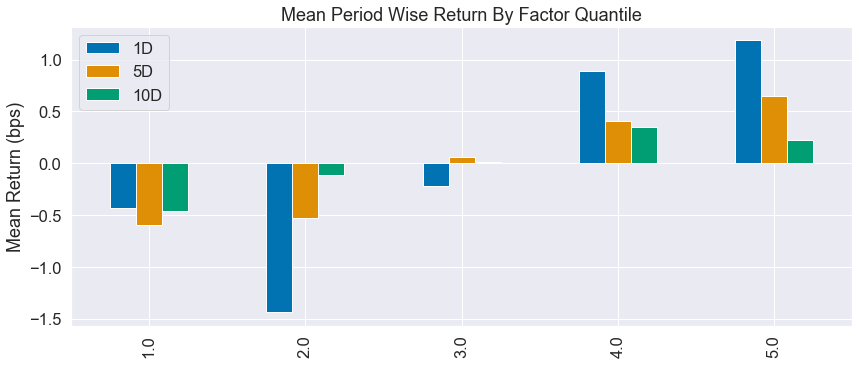

In [77]:
create_summary_tear_sheet(factor_data)